<a href="https://colab.research.google.com/github/OmarArias-Gaguancela/LOGOS_OAG/blob/main/QuickProt_PRM_Heavy_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/OmarArias-Gaguancela/LOGOS_OAG/main/QuickProt PRM.jpg" width="180" height="100">

# **QuickProt-PRM (Heavy label)**: This pipeline aims to analyze and visualize PRM proteomics data using the Skyline output table. This pipeline is specifically design to calculate the absolute number of copies of target proteins using heaby label standards/peptides (e.g. QconCATs)

## **Requirements:**
### 1. Create a folder in **MyDrive** where analyzed data will be stored
### 2. Save Skyline output table **"PRM_RESULTS_Heavy_label.csv"** in the above created folder
### 3. Molecular weight of your heavy labelled internal standads (HLIS)
### 4. Amount of spiked HLIS in your samples
### 5. Amount of sample that was injected in LC-MS/MS

## **Outputs:**
### 1. All spreadsheets will be stored in a folder called **"TABLES"**
### 2. All figures will be stored in a folder called **"PLOTS"**

###Below the layout of expected inputs and outputs:

<img src="https://raw.githubusercontent.com/OmarArias-Gaguancela/LOGOS_OAG/main/QuickProt_PRM_Heavy_label_input_output.jpg" width="580" height="200">

###Below the layout of the Skyline input table "PRM_RESULTS_Heavy_label.csv":

<img src="https://raw.githubusercontent.com/OmarArias-Gaguancela/LOGOS_OAG/main/QuickProt_PRM_Heavy_label_input_table.jpg" width="1900" height="180">

###**Note:** The column headings in this table are selected in the report settings of the Skyline software.

In [ ]:
#@title ##**Mounts drive and changes the directory to the folder previously created**

from google.colab import drive
import os
from IPython.display import display
import ipywidgets as widgets

# Mount Google Drive
drive.mount('/content/drive')

# Create a text input widget with a longer line
folder_input = widgets.Text(
    value='',
    placeholder='Enter the name of the folder you created',
    description='Folder:',
    layout=widgets.Layout(width='50%')
)

# Display the widget
display(folder_input)

# Function to change directory based on user input
def change_directory(change):
    folder_name = change['new']
    os.chdir(f'/content/drive/MyDrive/{folder_name}')
    print(f"Current directory: {os.getcwd()}")

# Link the widget to the function
folder_input.observe(change_directory, names='value')



Mounted at /content/drive


Text(value='', description='Folder:', layout=Layout(width='50%'), placeholder='Enter the name of the folder yo…

Current directory: /content/drive/MyDrive/QUICKPROT_FOR_MANUSCRIPT/PRM_Heavy_label_Skyline


In [ ]:
#@title **Install neccesary packages**
import os

os.system('pip install joypy > /dev/null 2>&1')
os.system('pip install pandas numpy statsmodels compactletterdisplay > /dev/null 2>&1')
os.system('pip install -U scikit-learn > /dev/null 2>&1')
os.system('pip install scikit-posthocs > /dev/null 2>&1')
os.system('pip install gprofiler-official > /dev/null 2>&1')
os.system('pip install compactletterdisplay > /dev/null 2>&1')
print("Packages were installed successfully.")



Packages were installed successfully.


In [ ]:
#@title **Heavy labelled internal standad (HLIS) (e.g. QconCAT) information**
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display

output_dir = 'TABLES'
os.makedirs(output_dir, exist_ok=True)

output_dir = 'PLOTS'
os.makedirs(output_dir, exist_ok=True)

def input_qconcat_data(num_qconcats):
    qconcat_data = []
    for i in range(num_qconcats):
        name = input(f'Enter the name of HLIS {i + 1}: ')
        molecular_weight = float(input(f'Enter the molecular weight of {name} (g/mol): '))
        qconcat_data.append({'Peptide Note': name, 'Molecular Weight (g/mol)': molecular_weight})
    return pd.DataFrame(qconcat_data)

num_qconcats = int(input('Enter the number of HLIS: '))
df = input_qconcat_data(num_qconcats)
amount = float(input('Enter the amount of spiked HLIS (ng): '))
df['Amount of injected HLIS (ng)'] = amount
df['Amount of injected HLIS (g)'] = df['Amount of injected HLIS (ng)'] * 1e-9
df['Number of femtomoles of spiked HLIS'] = (df['Amount of injected HLIS (g)'] / df['Molecular Weight (g/mol)']) / 1e-15
df.to_csv("TABLES/HLIS_spiked_amounts.csv")
print("Table saved as 'TABLES/HLIS_spiked_amounts.csv'")
def on_button_click(b):
    display(df)

button = widgets.Button(
    description="Display HLIS table",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)
button.on_click(on_button_click)
display(button)


Enter the number of HLIS: 4
Enter the name of HLIS 1: QconCAT09
Enter the molecular weight of QconCAT09 (g/mol): 58222.47
Enter the name of HLIS 2: QconCAT10
Enter the molecular weight of QconCAT10 (g/mol): 58564.44
Enter the name of HLIS 3: QconCAT11
Enter the molecular weight of QconCAT11 (g/mol): 63462.66
Enter the name of HLIS 4: QconCAT12
Enter the molecular weight of QconCAT12 (g/mol): 50649.33
Enter the amount of spiked HLIS (ng): 0.125
Table saved as 'TABLES/HLIS_spiked_amounts.csv'


Button(description='Display HLIS table', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_…

In [ ]:
#@title **Calculation of Heavy to Light Ratios and Protein Amount per QconCAT**
import pandas as pd
import numpy as np

file_path1 = 'PRM_RESULTS_Heavy_label.csv'
df = pd.read_csv(file_path1)

column_mapping = {'Protein Preferred Name': 'Protein Name'}
df.rename(columns=column_mapping, inplace=True)
column_mapping = {'Protein Gene': 'Genes'}
df.rename(columns=column_mapping, inplace=True)

df = df.sort_values(['Protein Name', 'Batch Name', 'Isotope Label Type', 'Peptide Sequence', 'Total Area'], ascending=[True, True, True, True, False])
grouped = df.groupby(['Protein Name', 'Batch Name', 'Isotope Label Type', 'Peptide Sequence']).first().reset_index()
filtered_grouped = grouped.dropna(subset=['Total Area'])

filtered_grouped1 = filtered_grouped.pivot_table(index=["Protein Name", 'Genes', "Peptide Note", "Peptide Sequence", "Batch Name", "Experimental groups"], values="Total Area", columns="Isotope Label Type")
filtered_grouped1["Ratio H/L"] = filtered_grouped1["heavy"] / filtered_grouped1["light"]
filtered_grouped1.replace([np.inf, -np.inf], np.nan, inplace=True)
filtered_grouped1.dropna(subset=["Ratio H/L"], inplace=True)
filtered_grouped1.reset_index(inplace=True)
filtered_grouped1.to_csv('TABLES/Heavy_to_Light_Ratios.csv', index=False)
print("Table saved as 'TABLES/Heavy_to_Light_Ratios.csv'")

file_path2 = 'TABLES/HLIS_spiked_amounts.csv'
df1 = pd.read_csv(file_path2)
file_path3 = 'TABLES/Heavy_to_Light_Ratios.csv'
df2 = pd.read_csv(file_path3)
merged_df = pd.merge(df1, df2, on='Peptide Note')
merged_df['Amount of endogenous protein [femtomoles]'] = (merged_df['Number of femtomoles of spiked HLIS'] * merged_df['light']) / merged_df['heavy']
final_df = merged_df[['Protein Name', 'Genes', 'Batch Name', 'Experimental groups', 'heavy', 'light', 'Ratio H/L', 'Peptide Note', 'Number of femtomoles of spiked HLIS', 'Amount of endogenous protein [femtomoles]']]
final_df.to_csv('TABLES/Protein_amount_per_HLIS.csv', index=False)
print("Table saved as 'TABLES/Protein_amount_per_HLIS.csv'")


Table saved as 'TABLES/Heavy_to_Light_Ratios.csv'
Table saved as 'TABLES/Protein_amount_per_HLIS.csv'


In [ ]:
#@title **Imput material and calculation of copy number per nucleus or cell**
import pandas as pd

file_path1 = 'TABLES/Protein_amount_per_HLIS.csv'
df1 = pd.read_csv(file_path1)

micrograms_input = float(input("Enter the micrograms of cell lysate injected in LC-MS/MS: "))
picograms = micrograms_input * 1e6

use_same_pg = input("Do you want to use the same value of 'picograms per nucleus or cell' for all experimental groups? (yes/no): ").strip().lower()

if use_same_pg == 'yes':
    pg_per_nucleus_or_cell = float(input("Enter the picograms per nucleus or cell: "))
    df1['Amount of endogenous protein [femtomoles]'] = (df1['Number of femtomoles of spiked HLIS'] * df1['light']) / df1['heavy']
    df1['Copy number'] = df1['Amount of endogenous protein [femtomoles]'] * 1e-15 * 6.022e23
    nucleus_or_cell = picograms / pg_per_nucleus_or_cell
    df1['Copy number per nucleus or cell'] = df1['Copy number'] / nucleus_or_cell
else:
    experimental_groups = df1['Experimental groups'].unique()
    pg_values = {}

    for group in experimental_groups:
        pg_values[group] = float(input(f"Enter the picograms per nucleus or cell for experimental group '{group}': "))

    pg_df = pd.DataFrame(list(pg_values.items()), columns=['Experimental groups', 'Picograms per nucleus or cell'])
    pg_df.to_csv('TABLES/input_pg_per_nucleus_or_cell_in_experimental_groups.csv', index=False)

    df1['Amount of endogenous protein [femtomoles]'] = (df1['Number of femtomoles of spiked HLIS'] * df1['light']) / df1['heavy']
    df1['Copy number'] = df1['Amount of endogenous protein [femtomoles]'] * 1e-15 * 6.022e23

    def calculate_copy_number(row):
        group = row['Experimental groups']
        pg_per_nucleus_or_cell = pg_values[group]
        nucleus_or_cell = picograms / pg_per_nucleus_or_cell
        return row['Copy number'] / nucleus_or_cell

    df1['Copy number per nucleus or cell'] = df1.apply(calculate_copy_number, axis=1)

final_df = df1[['Protein Name', 'Genes', 'Batch Name', 'Experimental groups', 'heavy', 'light', 'Ratio H/L', 'Peptide Note', 'Number of femtomoles of spiked HLIS', 'Amount of endogenous protein [femtomoles]', 'Copy number', 'Copy number per nucleus or cell']]
final_df.to_csv('TABLES/Protein_amount_copy_number_per_nucleus_or_cell.csv', index=False)
print("Table saved as 'TABLES/Protein_amount_copy_number_per_nucleus_or_cell.csv'")


Enter the micrograms of cell lysate injected in LC-MS/MS: 0.5
Do you want to use the same value of 'picograms per nucleus or cell' for all experimental groups? (yes/no): no
Enter the picograms per nucleus or cell for experimental group 'D0': 3.657143
Enter the picograms per nucleus or cell for experimental group 'D10': 6.336634
Enter the picograms per nucleus or cell for experimental group 'D11': 5.894737
Enter the picograms per nucleus or cell for experimental group 'D12': 4.723404
Enter the picograms per nucleus or cell for experimental group 'D14': 6.021505
Enter the picograms per nucleus or cell for experimental group 'D2': 3.413333
Enter the picograms per nucleus or cell for experimental group 'D4': 3.577889
Enter the picograms per nucleus or cell for experimental group 'D6': 3.679144
Enter the picograms per nucleus or cell for experimental group 'D8': 5.333333
Table saved as 'TABLES/Protein_amount_copy_number_per_nucleus_or_cell.csv'


### **Calculation of parameters for plots**
- Calculates the mean, median, standard deviation, and coefficient of variation
- Pivots tables, this makes it easier when plotting heatmaps
- Calculates the number of proteins and peptides in a dataset
- Calculates the number of peptides utlized to determine the relative abundance of a given protein

In [ ]:
#@title **Copy number per nucleus or cell - Per replicate**
import pandas as pd
import numpy as np

file_path = 'TABLES/Protein_amount_copy_number_per_nucleus_or_cell.csv'
df = pd.read_csv(file_path)

df['Median Copy number per nucleus or cell per replicate'] = df.groupby(['Protein Name', 'Batch Name'])['Copy number per nucleus or cell'].transform('median')
df['Median Copy number per nucleus or cell per replicate'] = df['Median Copy number per nucleus or cell per replicate'].round(3)

df['Std Error per replicate'] = df.groupby(['Protein Name', 'Batch Name'])['Copy number per nucleus or cell'].transform('std') / np.sqrt(df.groupby(['Protein Name', 'Batch Name'])['Copy number per nucleus or cell'].transform('count'))
df['Std Error per replicate'] = df['Std Error per replicate'].round(3)

final_df = df[['Protein Name', 'Genes','Batch Name', 'Experimental groups', 'Copy number per nucleus or cell', 'Median Copy number per nucleus or cell per replicate', 'Std Error per replicate']]
final_df.to_csv('TABLES/Protein_amount_copy_number_per_nucleus_or_cell_median_HLIS_per_replicate.csv', index=False)
print("Table saved as 'TABLES/Protein_amount_copy_number_per_nucleus_or_cell_median_HLIS_per_replicate.csv'")
final_df.head()

Table saved as 'TABLES/Protein_amount_copy_number_per_nucleus_or_cell_median_HLIS_per_replicate.csv'


,Protein Name,Genes,Batch Name,Experimental groups,Copy number per nucleus or cell,Median Copy number per nucleus or cell per replicate,Std Error per replicate
0,ACL6A_HUMAN,ACTL6A,D0_rep1,D0,14475.267359,27866.240,5217.882
1,ACL6A_HUMAN,ACTL6A,D0_rep2,D0,13759.347223,25705.788,5887.977
2,ACL6A_HUMAN,ACTL6A,D10_rep1,D10,22632.023110,44940.439,9739.145
3,ACL6A_HUMAN,ACTL6A,D10_rep2,D10,20714.968027,39465.509,6842.576
4,ACL6A_HUMAN,ACTL6A,D11_rep1,D11,19876.424968,42094.191,8194.366


In [ ]:
#@title **Copy number per nucleus or cell - Per experimental group**
import pandas as pd

df = pd.read_csv('TABLES/Protein_amount_copy_number_per_nucleus_or_cell_median_HLIS_per_replicate.csv')

df['Median Abundance for Experimental Group'] = df.groupby(['Experimental groups', 'Protein Name'])['Median Copy number per nucleus or cell per replicate'].transform('median')
df['Mean Abundance for Experimental Group'] = df.groupby(['Experimental groups', 'Protein Name'])['Median Copy number per nucleus or cell per replicate'].transform('mean')
df['Standard Deviation for Experimental Group'] = df.groupby(['Experimental groups', 'Protein Name'])['Median Copy number per nucleus or cell per replicate'].transform('std')
df['Coefficient of Variation for Experimental Group'] = (df['Standard Deviation for Experimental Group'] / df['Mean Abundance for Experimental Group']) * 100

result = df[['Protein Name', 'Genes', 'Batch Name', 'Experimental groups', 'Median Copy number per nucleus or cell per replicate', 'Median Abundance for Experimental Group', 'Standard Deviation for Experimental Group', 'Coefficient of Variation for Experimental Group']]
result.to_csv('TABLES/Absolute_quantitative_parameters.csv', index=False)
print("Table saved as 'TABLES/Absolute_quantitative_parameters.csv'")
result.head()

Table saved as 'TABLES/Absolute_quantitative_parameters.csv'


,Protein Name,Genes,Batch Name,Experimental groups,Median Copy number per nucleus or cell per replicate,Median Abundance for Experimental Group,Standard Deviation for Experimental Group,Coefficient of Variation for Experimental Group
0,ACL6A_HUMAN,ACTL6A,D0_rep1,D0,27866.240,26786.0140,1154.810169,4.311243
1,ACL6A_HUMAN,ACTL6A,D0_rep2,D0,25705.788,26786.0140,1154.810169,4.311243
2,ACL6A_HUMAN,ACTL6A,D10_rep1,D10,44940.439,42202.9740,2926.473182,6.934282
3,ACL6A_HUMAN,ACTL6A,D10_rep2,D10,39465.509,42202.9740,2926.473182,6.934282
4,ACL6A_HUMAN,ACTL6A,D11_rep1,D11,42094.191,41308.7675,839.653040,2.032627


In [ ]:
#@title **Pivot table Median abundance of Copy number per nucleus or cell - Per experimental group**

import pandas as pd

df = pd.read_csv('TABLES/Absolute_quantitative_parameters.csv')
df = df[['Protein Name', 'Genes', 'Experimental groups', 'Median Abundance for Experimental Group']]
pivot_df = df.pivot_table(index=['Protein Name', 'Genes'], columns=['Experimental groups'], values='Median Abundance for Experimental Group', aggfunc='first')
pivot_df.reset_index(inplace=True)
pivot_df.drop_duplicates(subset=['Protein Name'], inplace=True)
pivot_df.to_csv('TABLES/median_abundance.csv', index=False)
print("Table saved as 'TABLES/median_abundance.csv'")
pivot_df.head()

Table saved as 'TABLES/median_abundance.csv'


Experimental groups,Protein Name,Genes,D0,D10,D11,D12,D14,D2,D4,D6,D8
0,ACL6A_HUMAN,ACTL6A,26786.0140,42202.9740,41308.7675,20448.6700,18483.161,29197.0645,27466.0065,26836.1475,33299.1685
1,ACL6B_HUMAN,ACTL6B,1540.0605,4705.3020,5000.4710,2827.4445,4162.793,1819.5075,2238.3670,2089.9345,2618.9875
2,ARI1A_HUMAN,ARID1A,2371.4275,5720.0285,6545.9585,2639.6815,1738.734,5914.5785,3659.5080,3212.4425,7653.2645
3,ARI1B_HUMAN,ARID1B,1828.0605,2676.4435,2714.6915,1480.5540,1249.180,3172.1565,1515.6315,1466.8570,2981.5340
4,BCL7A_HUMAN,BCL7A,6057.7400,6585.4425,6245.9080,3296.2685,2184.305,8286.7825,5819.7755,5181.8435,6364.7315


In [ ]:
#@title **Pivot table for Coeficients of variation - Per experimental group**

import pandas as pd
df = pd.read_csv('TABLES/Absolute_quantitative_parameters.csv')
df = df[['Protein Name', 'Genes','Experimental groups', 'Coefficient of Variation for Experimental Group']]
pivot_df = df.pivot_table(index=['Protein Name', 'Genes'], columns=['Experimental groups'], values='Coefficient of Variation for Experimental Group', aggfunc='first')
pivot_df.reset_index(inplace=True)
pivot_df.drop_duplicates(subset=['Protein Name'], inplace=True)
pivot_df.to_csv('TABLES/Coeficient_Variation.csv', index=False)
print("Table saved as 'TABLES/Coeficient_Variation.csv'")
pivot_df.head()

Table saved as 'TABLES/Coeficient_Variation.csv'


Experimental groups,Protein Name,Genes,D0,D10,D11,D12,D14,D2,D4,D6,D8
0,ACL6A_HUMAN,ACTL6A,4.311243,6.934282,2.032627,1.543394,19.954453,5.332656,3.100372,2.119369,6.511489
1,ACL6B_HUMAN,ACTL6B,15.699749,4.536492,17.524925,20.062963,24.096606,0.542951,2.537603,17.698771,14.263177
2,ARI1A_HUMAN,ARID1A,11.462753,2.733246,4.253713,4.221023,15.776697,2.125630,4.562539,0.334095,1.956897
3,ARI1B_HUMAN,ARID1B,0.500791,5.666577,5.512390,5.647933,28.258429,14.672643,37.473811,0.943358,4.156768
4,BCL7A_HUMAN,BCL7A,9.118614,1.717204,1.067333,4.215116,3.517689,7.085887,0.726805,4.391222,20.720480


In [ ]:
#@title **Number of peptides - Per experimental group**

import pandas as pd

df = pd.read_csv('TABLES/Heavy_to_Light_Ratios.csv')
counts = df.groupby(['Batch Name', 'Experimental groups'])['Peptide Sequence'].count().reset_index()
counts.columns = ['Batch Name', 'Experimental groups', 'Number of Peptides']
counts.to_csv('TABLES/Number_peptides.csv', index=False)
print("Table saved as 'TABLES/Number_peptides.csv'")
counts.head()

Table saved as 'TABLES/Number_peptides.csv'


,Batch Name,Experimental groups,Number of Peptides
0,D0_rep1,D0,53
1,D0_rep2,D0,54
2,D10_rep1,D10,54
3,D10_rep2,D10,54
4,D11_rep1,D11,47


In [ ]:
#@title **Number of proteins - Per experimental group**

import pandas as pd

df = pd.read_csv('TABLES/Heavy_to_Light_Ratios.csv')
counts = df.groupby(['Batch Name', 'Experimental groups'])['Protein Name'].nunique().reset_index()
counts.columns = ['Batch Name', 'Experimental groups', 'Number of Proteins']
counts.to_csv('TABLES/Number_proteins.csv', index=False)
print("Table saved as 'TABLES/Number_proteins.csv'")
counts.head()

Table saved as 'TABLES/Number_proteins.csv'


,Batch Name,Experimental groups,Number of Proteins
0,D0_rep1,D0,21
1,D0_rep2,D0,21
2,D10_rep1,D10,21
3,D10_rep2,D10,21
4,D11_rep1,D11,20


In [ ]:
#@title **Number of peptides for each protein - Per experimental group**

import pandas as pd

file_path = 'TABLES/Heavy_to_Light_Ratios.csv'
df = pd.read_csv(file_path)

filtered_df = df[df['Experimental groups'].notnull()]
counts = filtered_df.groupby(['Protein Name', 'Genes', 'Experimental groups'])['Peptide Sequence'].nunique().reset_index()
counts.columns = ['Protein Name', 'Genes','Experimental groups','#Peptides per protein']
counts.to_csv('TABLES/number_peptides_per_protein_per_group.csv', index=False)
print("Table saved as 'TABLES/number_peptides_per_protein_per_group.csv'")
counts.head()

Table saved as 'TABLES/number_peptides_per_protein_per_group.csv'


,Protein Name,Genes,Experimental groups,#Peptides per protein
0,ACL6A_HUMAN,ACTL6A,D0,4
1,ACL6A_HUMAN,ACTL6A,D10,4
2,ACL6A_HUMAN,ACTL6A,D11,4
3,ACL6A_HUMAN,ACTL6A,D12,4
4,ACL6A_HUMAN,ACTL6A,D14,4


In [ ]:
#@title **Number of peptides per protein for experimental groups**

import pandas as pd

df = pd.read_csv('TABLES/number_peptides_per_protein_per_group.csv')
df = df[['Protein Name', 'Genes', 'Experimental groups','#Peptides per protein']]
pivot_df = df.pivot_table(index=['Protein Name', 'Genes'], columns=['Experimental groups']	, values='#Peptides per protein', aggfunc='first')
pivot_df.reset_index(inplace=True)
pivot_df.drop_duplicates(subset=['Protein Name'], inplace=True)
pivot_df.to_csv('TABLES/melted_number_peptides_per_protein_per_group.csv', index=False)
print("Table saved as 'TABLES/melted_number_peptides_per_protein_per_group.csv'")
pivot_df.head()

Table saved as 'TABLES/melted_number_peptides_per_protein_per_group.csv'


Experimental groups,Protein Name,Genes,D0,D10,D11,D12,D14,D2,D4,D6,D8
0,ACL6A_HUMAN,ACTL6A,4,4,4,4,4,4,4,4,4
1,ACL6B_HUMAN,ACTL6B,2,2,2,2,2,2,2,2,2
2,ARI1A_HUMAN,ARID1A,3,3,3,3,3,2,3,3,3
3,ARI1B_HUMAN,ARID1B,4,4,4,4,4,4,4,4,4
4,BCL7A_HUMAN,BCL7A,1,1,1,1,1,1,1,1,1


In [ ]:
#@title **MS2 data points across peak**
import os
import pandas as pd

file_name = 'PRM_RESULTS_Heavy_label.csv'
df = pd.read_csv(file_name)

column_mapping = {
    'Protein Preferred Name': 'Protein Name',
    'Protein Gene': 'Genes'
}
df.rename(columns=column_mapping, inplace=True)

df_filtered = df[['Protein Name', 'Genes', 'Experimental groups', 'Points Across Peak']].copy()
df_filtered.loc[:, 'Points Across Peak'] = pd.to_numeric(df_filtered['Points Across Peak'], downcast='float')

pivot_df = df_filtered.pivot_table(
    index=['Protein Name', 'Genes'],
    columns=['Experimental groups'],
    values='Points Across Peak',
    aggfunc='first'
)

pivot_df.reset_index(inplace=True)
pivot_df.drop_duplicates(subset=['Protein Name', 'Genes'], inplace=True)

output_dir = 'TABLES'
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, 'points_across_peak_MS2.csv')
pivot_df.to_csv(output_file, index=False)
print(f"Pivoted data saved to '{output_file}'")
pivot_df.head()

Pivoted data saved to 'TABLES/points_across_peak_MS2.csv'


Experimental groups,Protein Name,Genes,D0,D10,D11,D12,D14,D2,D4,D6,D8
0,ACL6A_HUMAN,ACTL6A,37.0,44.0,42.0,31.0,36.0,39.0,40.0,34.0,44.0
1,ACL6B_HUMAN,ACTL6B,22.0,31.0,59.0,20.0,31.0,27.0,21.0,19.0,29.0
2,ARI1A_HUMAN,ARID1A,32.0,30.0,28.0,32.0,43.0,31.0,32.0,33.0,32.0
3,ARI1B_HUMAN,ARID1B,49.0,43.0,44.0,45.0,42.0,39.0,36.0,46.0,42.0
4,BCL7A_HUMAN,BCL7A,29.0,31.0,27.0,32.0,30.0,27.0,28.0,26.0,24.0


##**Rearrange the order of groups/samples**

In [ ]:
#@title **Rearrange the order of groups**
#@markdown - Click on "Update" whether reorganization was necessary or not

import pandas as pd
import ipywidgets as widgets
from IPython.display import display

peptide_counts_df = pd.read_csv('TABLES/Number_peptides.csv')
protein_counts_df = pd.read_csv('TABLES/Number_proteins.csv')
quantitative_parameters_df = pd.read_csv('TABLES/Absolute_quantitative_parameters.csv').rename(columns={'Batch Name': 'Sample'})
pivot_Absolute_quantitative_parameters_df = pd.read_csv('TABLES/median_abundance.csv')
CVs_df = pd.read_csv('TABLES/Coeficient_Variation.csv')
melted_number_peptides_per_protein_per_group_df = pd.read_csv('TABLES/melted_number_peptides_per_protein_per_group.csv')
points_across_peak_MS2_df = pd.read_csv('TABLES/points_across_peak_MS2.csv')

group_names = peptide_counts_df['Experimental groups'].unique().tolist()
group_order = widgets.SelectMultiple(
    options=group_names,
    value=tuple(group_names),
    description='Groups:',
    layout=widgets.Layout(width='50%', height='200px'),
    style={'description_width': 'initial'}
)

move_up_button = widgets.Button(description="Move Up", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))
move_down_button = widgets.Button(description="Move Down", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))
reorder_tables_button = widgets.Button(description="Update groups", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))

def move_up(change):
    selected = list(group_order.value)
    options = list(group_order.options)
    for item in selected:
        idx = options.index(item)
        if idx > 0:
            options[idx], options[idx - 1] = options[idx - 1], options[idx]
            group_order.value = tuple(options)
            group_order.options = options

def move_down(change):
    selected = list(group_order.value)
    options = list(group_order.options)
    for item in reversed(selected):
        idx = options.index(item)
        if idx < len(options) - 1:
            options[idx], options[idx + 1] = options[idx + 1], options[idx]
            group_order.value = tuple(options)
            group_order.options = options

def reorder_tables(change):
    new_order = list(group_order.options)

    peptide_counts_df['Experimental groups'] = pd.Categorical(peptide_counts_df['Experimental groups'], categories=new_order, ordered=True)
    reordered_peptide_counts_df = peptide_counts_df.sort_values('Experimental groups')

    protein_counts_df['Experimental groups'] = pd.Categorical(protein_counts_df['Experimental groups'], categories=new_order, ordered=True)
    reordered_protein_counts_df = protein_counts_df.sort_values('Experimental groups')

    quantitative_parameters_df['Experimental groups'] = pd.Categorical(quantitative_parameters_df['Experimental groups'], categories=new_order, ordered=True)
    reordered_quantitative_parameters_df = quantitative_parameters_df.sort_values('Experimental groups')

    pivot_Absolute_quantitative_parameters_columns = ['Protein Name', 'Genes'] + [col for col in new_order if col in pivot_Absolute_quantitative_parameters_df.columns]
    reordered_pivot_Absolute_quantitative_parameters_df = pivot_Absolute_quantitative_parameters_df[pivot_Absolute_quantitative_parameters_columns]

    CVs_columns = ['Protein Name', 'Genes'] + [col for col in new_order if col in CVs_df.columns]
    reordered_CVs_df = CVs_df[CVs_columns]

    melted_number_peptides_per_protein_per_group_columns = ['Protein Name', 'Genes'] + [col for col in new_order if col in melted_number_peptides_per_protein_per_group_df.columns]
    reordered_melted_number_peptides_per_protein_per_group_df = melted_number_peptides_per_protein_per_group_df[melted_number_peptides_per_protein_per_group_columns]

    points_across_peak_MS2_columns = ['Protein Name', 'Genes'] + [col for col in new_order if col in points_across_peak_MS2_df.columns]
    reordered_points_across_peak_MS2_df = points_across_peak_MS2_df[points_across_peak_MS2_columns]

    reordered_peptide_counts_df.to_csv('TABLES/Number_peptides.csv', index=False)
    reordered_protein_counts_df.to_csv('TABLES/Number_proteins.csv', index=False)
    reordered_quantitative_parameters_df.to_csv('TABLES/Absolute_quantitative_parameters.csv', index=False)
    reordered_pivot_Absolute_quantitative_parameters_df.to_csv('TABLES/median_abundance.csv', index=False)
    reordered_CVs_df.to_csv('TABLES/Coeficient_Variation.csv', index=False)
    reordered_melted_number_peptides_per_protein_per_group_df.to_csv('TABLES/melted_number_peptides_per_protein_per_group.csv', index=False)
    reordered_points_across_peak_MS2_df.to_csv('TABLES/points_across_peak_MS2.csv', index=False)

move_up_button.on_click(move_up)
move_down_button.on_click(move_down)
reorder_tables_button.on_click(reorder_tables)

controls_box = widgets.VBox([move_up_button, move_down_button, reorder_tables_button])
display(widgets.HBox([group_order, controls_box]))


df = pd.read_csv('TABLES/Absolute_quantitative_parameters.csv').rename(columns={'Batch Name': 'Sample'})
df = df.drop_duplicates(subset=['Protein Name', 'Sample'])

sample_names = df['Sample'].unique().tolist()

sample_order = widgets.SelectMultiple(
    options=sample_names,
    value=tuple(sample_names),
    description='Samples:',
    layout=widgets.Layout(width='50%', height='200px'),
    style={'description_width': 'initial'}
)

move_up_sample_button = widgets.Button(description="Move Up", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))
move_down_sample_button = widgets.Button(description="Move Down", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))
reorder_samples_button = widgets.Button(description="Update samples", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(width='auto'))

def move_up_sample(change):
    selected = list(sample_order.value)
    options = list(sample_order.options)
    for item in selected:
        idx = options.index(item)
        if idx > 0:
            options[idx], options[idx - 1] = options[idx - 1], options[idx]
            sample_order.value = tuple(options)
            sample_order.options = options

def move_down_sample(change):
    selected = list(sample_order.value)
    options = list(sample_order.options)
    for item in reversed(selected):
        idx = options.index(item)
        if idx < len(options) - 1:
            options[idx], options[idx + 1] = options[idx + 1], options[idx]
            sample_order.value = tuple(options)
            sample_order.options = options

def reorder_samples(change):
    new_sample_order = list(sample_order.options)
    pivot_df = df.pivot_table(index=['Protein Name', 'Genes'], columns=['Sample'], values='Median Copy number per nucleus or cell per replicate', aggfunc='first')
    pivot_df = pivot_df[new_sample_order]
    pivot_df.reset_index(inplace=True)
    pivot_df.to_csv('TABLES/melted_protein_data_samples.csv', index=False)

move_up_sample_button.on_click(move_up_sample)
move_down_sample_button.on_click(move_down_sample)
reorder_samples_button.on_click(reorder_samples)

sample_controls_box = widgets.VBox([move_up_sample_button, move_down_sample_button, reorder_samples_button])
display(widgets.HBox([sample_order, sample_controls_box]))

##**Correlation among replicates**
- Plots the distribution of the dataset
- Calculates the Spearman's rank correlation coeficient among replicates

##**Coeficient of variation (CV)**
- Generates a violin plot for the CV, and also shows the median CV value for the entire dataset

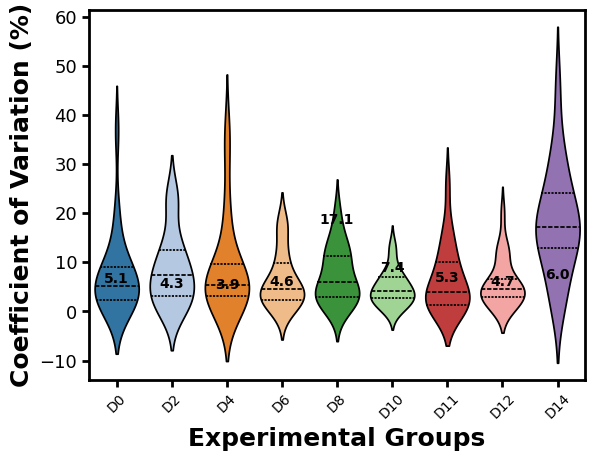

In [ ]:
#@title **CV plot**

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'TABLES/Coeficient_Variation.csv'
df = pd.read_csv(file_path)

plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_data(df):
    group_names = [col for col in df.columns if col not in ['Protein Name', 'Genes']]

    melted_df = df.melt(id_vars=['Protein Name'], value_vars=group_names, var_name='Group', value_name='Value')

    median_df = melted_df.groupby('Group')['Value'].median().reset_index()
    median_df.columns = ['Group', 'Median Value']
    melted_df = melted_df.merge(median_df, on='Group')

    sns.violinplot(x='Group', y='Value', hue='Group', data=melted_df, inner='quartile', palette='tab20', edgecolor='black', legend=False)
    for i, row in median_df.iterrows():
        plt.text(i, row['Median Value'], f'{row["Median Value"]:.1f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, fontweight='bold')

    plt.ylabel('Coefficient of Variation (%)', fontsize=18, fontweight='bold')
    plt.xlabel('Experimental Groups', fontsize=18, fontweight='bold')
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=13)

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    plt.savefig('PLOTS/CV_violin_plot.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

plot_data(df)





Text(value='', description='Samples:', layout=Layout(width='auto'), placeholder='Separated by commas (up to 3)…

Button(description='Plot Data', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_color='#4…

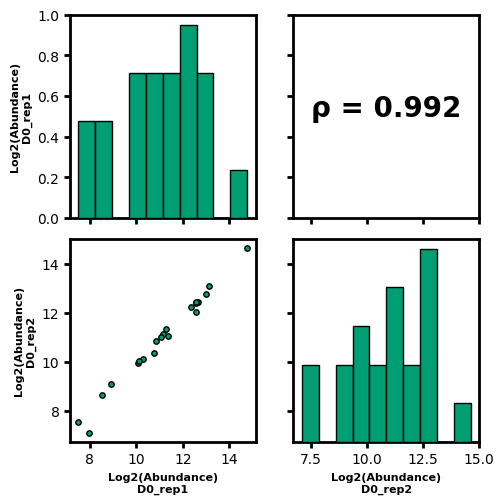

In [ ]:
#@title **Select samples for correlation plot**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import ipywidgets as widgets
from IPython.display import display

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/melted_protein_data_samples.csv'
df = pd.read_csv(file_path)

columns_input = widgets.Text(
    value='',
    placeholder='Separated by commas (up to 3)',
    description='Samples:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(description="Plot Data", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(
                width='auto',
                height='80px'
            ))

def update_plot(columns):
    columns_to_plot = [col.strip() for col in columns.split(',') if col.strip() in df.columns]
    if len(columns_to_plot) > 3:
        print("Please enter up to three column names.")
        return

    # Replace zero or negative values with NaN to avoid log2 issues using DataFrame.apply
    df[columns_to_plot] = df[columns_to_plot].apply(lambda col: col.map(lambda x: np.nan if x <= 0 else x))
    df[columns_to_plot] = np.log2(df[columns_to_plot])

    def annotate_corr(x, y, **kwargs):
        valid_idx = x.notna() & y.notna()
        x_valid = x[valid_idx]
        y_valid = y[valid_idx]

        if len(x_valid) > 1 and len(y_valid) > 1:
            rho, _ = spearmanr(x_valid, y_valid)
        else:
            rho = np.nan

        ax = plt.gca()
        x_pos = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2
        y_pos = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2
        ax.annotate(f'ρ = {rho:.3f}', xy=(x_pos, y_pos), xycoords='data', ha='center', fontsize=20, fontweight='bold')

    g = sns.PairGrid(df, vars=columns_to_plot, diag_sharey=False)
    g.map_diag(plt.hist, bins=10, edgecolor='black', color='#009E73')
    g.map_lower(plt.scatter, color='#009E73', edgecolor='black', s=15)
    g.map_upper(annotate_corr)

    for ax in g.axes.flat:
        if ax.get_xlabel():
            ax.set_xlabel('Log2(Abundance)\n' + ax.get_xlabel(), fontsize=8, fontweight='bold')
        if ax.get_ylabel():
            ax.set_ylabel('Log2(Abundance)\n' + ax.get_ylabel(), fontsize=8, fontweight='bold')
        ax.tick_params(axis='x', which='both', bottom=True, length=4, width=2, color='black')
        ax.tick_params(axis='y', which='both', left=True, length=4, width=2, color='black')
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    plt.savefig('PLOTS/correlation.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

def on_button_click(b):
    columns = columns_input.value
    update_plot(columns)

button.on_click(on_button_click)
display(columns_input, button)


##**Number of points Across Peak**

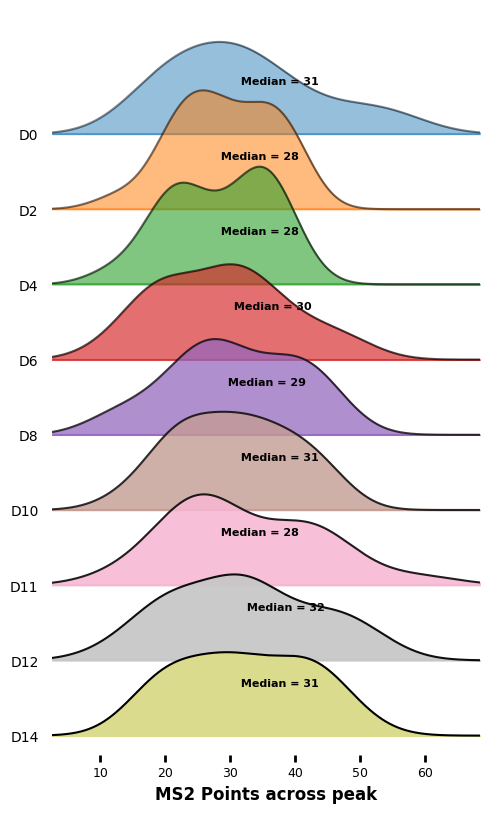

In [ ]:
#@title **Density plot: Number of MS2 points across peak**

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joypy

plt.rcParams['font.family'] = 'DejaVu Sans'
file_path = 'TABLES/points_across_peak_MS2.csv'
df = pd.read_csv(file_path)

def plot_data():
    group_names = [col for col in df.columns if col not in ['Protein Name', 'Genes']]

    melted_df = df.melt(id_vars=['Protein Name', 'Genes'], value_vars=group_names, var_name='Group', value_name='Value')
    grouped_data = [melted_df[melted_df['Group'] == group]['Value'].values for group in group_names]
    fig, axes = joypy.joyplot(data=grouped_data, labels=group_names[:len(grouped_data)], colormap=plt.get_cmap('tab20'), fade=True, figsize=(5, 8))

    plt.xlabel('MS2 Points across peak', fontsize=12, fontweight='bold')
    plt.ylabel('Density', fontsize=18, fontweight='bold')
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=15, fontweight='bold')

    for ax, group in zip(axes, group_names):
        median_value = round(df[group].median())
        ax.text(median_value, ax.get_ylim()[1] * 0.4, f' Median = {median_value}', color='black', fontsize=8, zorder=10, fontweight='bold')

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    plt.savefig('PLOTS/Density_points_across_peak_MS2.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

plot_data()

## **Number of peptides and proteins**
- Generates bar plots for individual replicates and for the median value of a  group of samples  

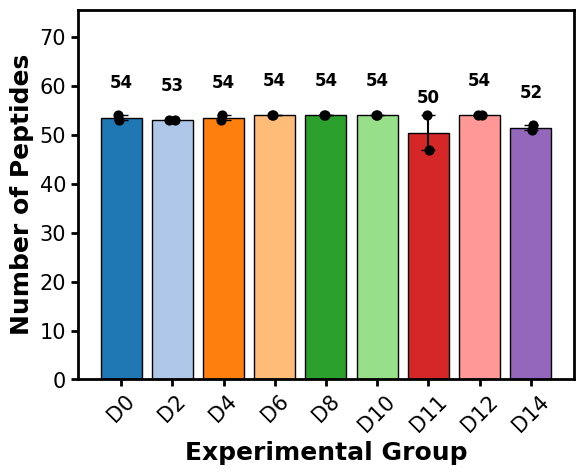

In [ ]:
#@title ##**Peptides: median values**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/Number_peptides.csv'
df = pd.read_csv(file_path)

def update_dataframe(df):
    group_order = df['Experimental groups'].unique()

    df['Experimental groups'] = pd.Categorical(df['Experimental groups'], categories=group_order, ordered=True)
    df = df.sort_values('Experimental groups')

    groups = df.groupby('Experimental groups', observed=True)['Number of Peptides'].apply(list).to_dict()
    medians = []
    std_devs = []
    all_values = []

    for group_name, values in groups.items():
        medians.append(np.median(values))
        std_devs.append(np.std(values))
        all_values.append(values)

    fig, ax = plt.subplots()
    colors = sns.color_palette('tab20', len(groups))
    bars = ax.bar(groups.keys(), medians, yerr=std_devs, capsize=5, color=colors, edgecolor='black')

    offset = max(std_devs) * 1.5

    for i, group in enumerate(groups.keys()):
        y = all_values[i]
        x = np.random.normal(i, 0.04, size=len(y))
        ax.scatter(x, y, edgecolor='black', facecolor='black', s=40, zorder=2)

    for bar, median in zip(bars, medians):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height + offset, f'{median:.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.xlabel('Experimental Group', fontsize=18, fontweight='bold')
    ax.set_ylabel('Number of Peptides', fontweight='bold', fontsize=18)
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45, fontsize=15)

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    ax.margins(y=0.4)

    plt.savefig('PLOTS/Number_peptides_median.tiff', format='tiff', dpi=300)
    plt.show()

update_dataframe(df)

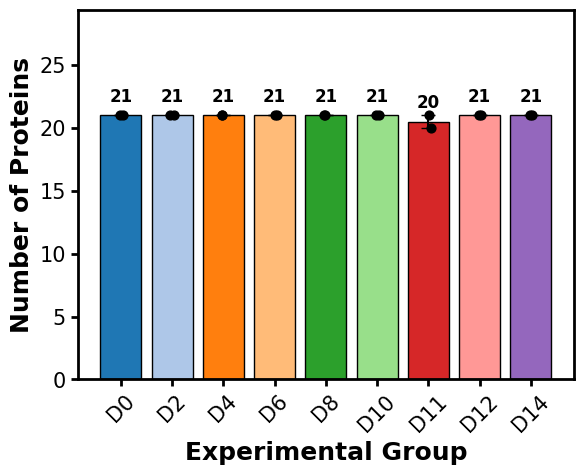

In [ ]:
#@title **Proteins: median values**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/Number_proteins.csv'
df = pd.read_csv(file_path)

os.makedirs('PLOTS', exist_ok=True)

def update_dataframe(df):
    group_order = df['Experimental groups'].unique()

    df['Experimental groups'] = pd.Categorical(df['Experimental groups'], categories=group_order, ordered=True)
    df = df.sort_values('Experimental groups')

    groups = df.groupby('Experimental groups', observed=True)['Number of Proteins'].apply(list).to_dict()
    medians = []
    std_devs = []
    all_values = []

    for group_name, values in groups.items():
        medians.append(np.median(values))
        std_devs.append(np.std(values))
        all_values.append(values)

    fig, ax = plt.subplots()
    colors = sns.color_palette('tab20', len(groups))
    bars = ax.bar(groups.keys(), medians, yerr=std_devs, capsize=5, color=colors, edgecolor='black')

    offset = max(std_devs) * 1.5
    for i, group in enumerate(groups.keys()):
        y = all_values[i]
        x = np.random.normal(i, 0.04, size=len(y))
        ax.scatter(x, y, edgecolor='black', facecolor='black', s=40, zorder=2)

    for bar, median in zip(bars, medians):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height + offset, f'{median:.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.xlabel('Experimental Group', fontsize=18, fontweight='bold')
    ax.set_ylabel('Number of Proteins', fontweight='bold', fontsize=18)
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45, fontsize=15)

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    ax.margins(y=0.4)

    plt.savefig('PLOTS/Number_proteins_median.tiff', format='tiff', dpi=300)
    plt.show()

update_dataframe(df)


##**Number of peptides per protein**
- Plots a density plot for the number of peptides that were used to calculate the relative abundance of the overall proteome

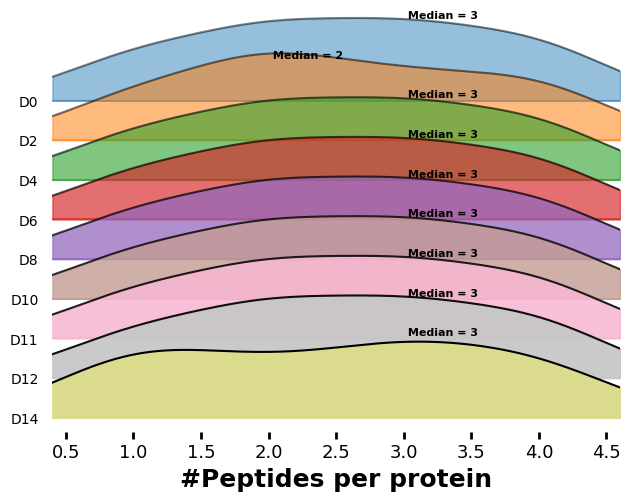

In [ ]:
#@title **Density plot**
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joypy
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams['font.family'] = 'DejaVu Sans'
file_path = 'TABLES/melted_number_peptides_per_protein_per_group.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['Genes'])

def plot_data(df):
    group_names = [col for col in df.columns if col not in ['Protein Name']]

    melted_df = df.melt(id_vars=['Protein Name'], value_vars=group_names, var_name='Group', value_name='Value')
    melted_df['Group'] = pd.Categorical(melted_df['Group'], categories=group_names, ordered=True)
    melted_df = melted_df.sort_values('Group')

    fig, axes = joypy.joyplot(data=melted_df, by='Group', column='Value', colormap=plt.get_cmap('tab20'), fade=True)

    plt.xlabel('#Peptides per protein', fontsize=18, fontweight='bold')
    plt.ylabel('Density', fontsize=18, fontweight='bold')
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=15, fontweight='bold')

    for ax, group in zip(axes, group_names):
        median_value = int(df[group].median())
        ax.text(median_value, ax.get_ylim()[1] * 0.9, f' Median = {median_value}', color='black', fontsize=8, fontweight='bold')

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    plt.savefig('PLOTS/Density_peptides_per_protein.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

plot_data(df)

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein Name', 'Genes'), style=Descr…

Text(value='', description='Name:', layout=Layout(width='auto'), placeholder='e.g., ACL6A_HUMAN or ACTL6A', st…

Button(description='Generate Plot', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_color…

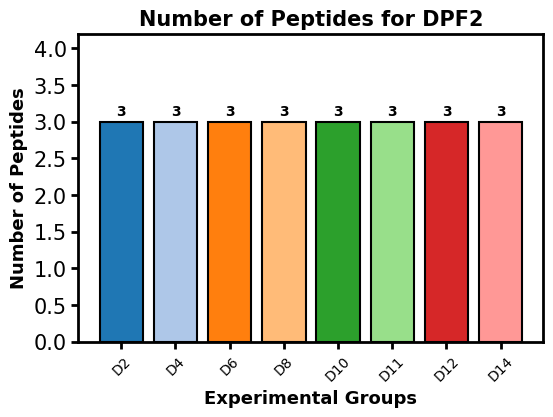

In [ ]:
#@title **Number of peptides for a given protein**
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

df = pd.read_csv('TABLES/melted_number_peptides_per_protein_per_group.csv')
def plot_protein_or_gene(name, search_by='Protein Name'):
    if search_by == 'Protein Name':
        data = df[df['Protein Name'] == name]
    elif search_by == 'Genes':
        data = df[df['Genes'] == name]
    else:
        print(f"Invalid search criteria: {search_by}")
        return

    if data.empty:
        print(f"No data found for {search_by}: {name}")
        return

    all_groups = df.columns[3:]
    all_groups_df = pd.DataFrame(columns=all_groups)
    all_groups_df.loc[0] = 0
    data = pd.concat([all_groups_df, data], ignore_index=True).fillna(0)
    values = data.iloc[1].reindex(all_groups, fill_value=0)

    colors = sns.color_palette("tab20", len(all_groups))

    plt.figure(figsize=(6, 4))
    bars = plt.bar(all_groups, values, edgecolor='black', color=colors, linewidth=1.5)
    plt.xlabel('Experimental Groups', fontsize=13, fontweight='bold')
    plt.ylabel('Number of Peptides', fontsize=13, fontweight='bold')
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.title(f'Number of Peptides for {name}', fontweight='bold', fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45, fontsize=10)

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        if pd.isna(yval) or yval == 0:
            plt.text(bar.get_x() + bar.get_width() / 2, 0.1, 'n.d.', ha='center', va='bottom', fontsize=15, color='red', fontweight='bold')
        else:
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    ax1.margins(y=0.4)
    plt.savefig(f'PLOTS/Number_peptides_for_{name}.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

search_by_dropdown = widgets.Dropdown(
    options=['Protein Name', 'Genes'],
    value='Protein Name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

name_input = widgets.Text(
    value='',
    placeholder='e.g., ACL6A_HUMAN or ACTL6A',
    description='Name:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(
    description="Generate Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)

def on_button_click(b):
    name = name_input.value
    search_by = search_by_dropdown.value
    plot_protein_or_gene(name, search_by)

button.on_click(on_button_click)

display(search_by_dropdown)
display(name_input)
display(button)

##**Exploratory Analysis**

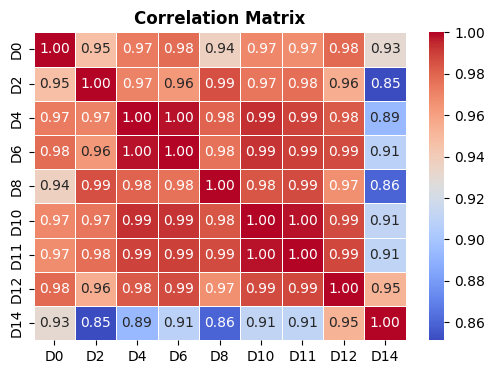

In [ ]:
#@title **Correlation Matrix**
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

file_path = 'TABLES/median_abundance.csv'
data = pd.read_csv(file_path)
data_values = data.iloc[:, 2:]
imputer = SimpleImputer(strategy='mean')
data_values_imputed = imputer.fit_transform(data_values)
correlation_matrix = pd.DataFrame(data_values_imputed, columns=data.columns[2:]).corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix',fontsize=12, fontweight='bold')
plt.savefig(f'PLOTS/Correlation_Matrix.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

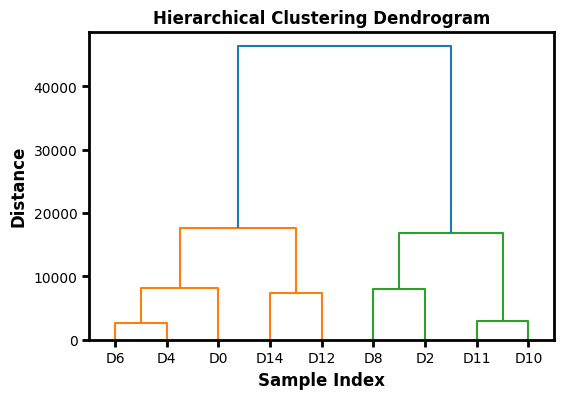

In [ ]:
#@title **Hierarchical Clustering Dendrogram**
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import dendrogram, linkage

file_path = 'TABLES/median_abundance.csv'
data = pd.read_csv(file_path)
data_values = data.iloc[:, 2:]
imputer = SimpleImputer(strategy='mean')
data_values_imputed = imputer.fit_transform(data_values)
linked = linkage(data_values_imputed.T, method='ward')
plt.figure(figsize=(6, 4))
dendrogram(linked,
           orientation='top',
           labels=data.columns[2:],
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram',fontsize=12, fontweight='bold')
plt.xlabel('Sample Index',fontsize=12, fontweight='bold')
plt.ylabel('Distance', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

ax = plt.gca()
ax.grid(False)
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color("k")
plt.savefig(f'PLOTS/Hierarchical_Clustering_Dendrogram.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

##**Visualization of Targeted Proteome**

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein Name', 'Genes'), style=Descr…

SelectMultiple(description='Target:', layout=Layout(width='auto'), options=(), style=DescriptionStyle(descript…

Dropdown(description='Y-axis title:', layout=Layout(width='auto'), options=('Copies/nucleus', 'Copies/cell'), …

Button(description='Generate Bar Plot', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_c…

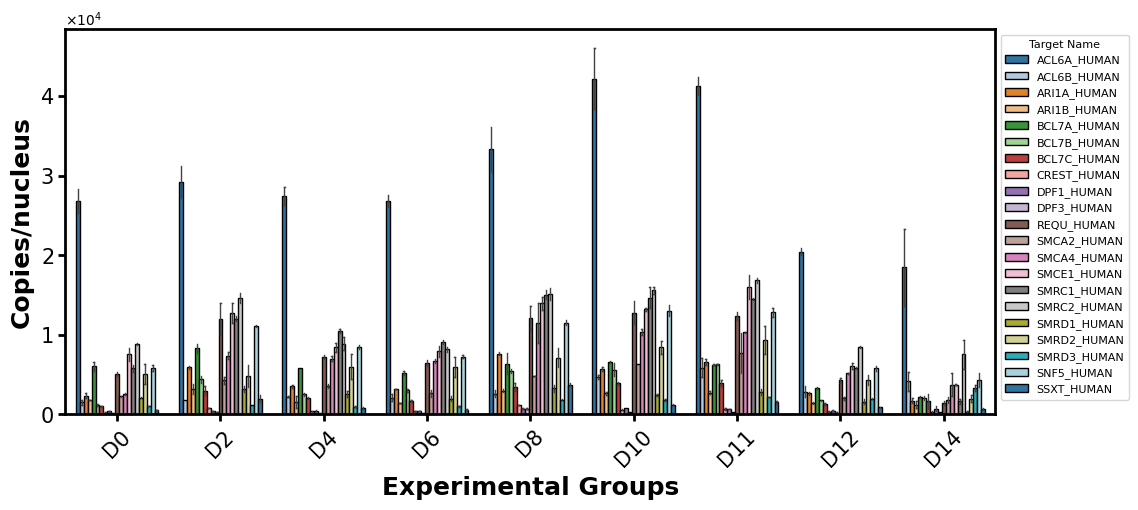

In [ ]:
#@title **Display Bar Plot**
import pandas as pd
import numpy as np
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['font.family'] = 'DejaVu Sans'

os.makedirs('PLOTS', exist_ok=True)

file_path = 'TABLES/Absolute_quantitative_parameters.csv'
df = pd.read_csv(file_path)

search_by_dropdown = widgets.Dropdown(
    options=['Protein Name', 'Genes'],
    value='Protein Name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

group_names_input = widgets.SelectMultiple(
    options=[],
    description='Target:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'},
    visible=False
)

y_axis_title_dropdown = widgets.Dropdown(
    options=['Copies/nucleus', 'Copies/cell'],
    value='Copies/nucleus',
    description='Y-axis title:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

def update_options(change):
    if change['new'] == 'Protein Name':
        options = df['Protein Name'].unique().tolist()
    else:
        options = df['Genes'].unique().tolist()

    group_names_input.options = options
    group_names_input.visible = True

search_by_dropdown.observe(update_options, names='value')

button = widgets.Button(
    description="Generate Bar Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)

def process_and_display_tables(b):
    selected_targets = group_names_input.value
    if search_by_dropdown.value == 'Protein Name':
        filtered_df = df[df['Protein Name'].isin(selected_targets)]
    else:
        filtered_df = df[df['Genes'].isin(selected_targets)]

    if filtered_df.empty:
        print("No data found for the selected targets.")
        return

    numeric_cols = filtered_df.select_dtypes(include=np.number).columns
    aggregated_df = filtered_df.groupby(['Sample', 'Protein Name', 'Experimental groups'])[numeric_cols].median().reset_index()

    pivot_table = aggregated_df.pivot_table(
        index=['Sample', 'Experimental groups', 'Protein Name'],
        values='Median Copy number per nucleus or cell per replicate'
    ).reset_index()

    pivot_table['Experimental groups'] = pd.Categorical(pivot_table['Experimental groups'], categories=df['Experimental groups'].unique(), ordered=True)

    df_melted = pivot_table.melt(id_vars=['Sample', 'Experimental groups', 'Protein Name'], value_name='value')

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(
        x='Experimental groups', y='value', hue='Protein Name', data=df_melted, ax=ax,
        palette='tab20', capsize=0.1, errorbar='sd', err_kws={'linewidth': 1}, edgecolor='black'
    )

    ax.set_title('', fontweight='bold', fontsize=18)
    ax.set_xlabel('Experimental Groups', fontsize=18, fontweight='bold')

    ax.set_ylabel(y_axis_title_dropdown.value, fontsize=18, fontweight='bold')

    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(rotation=45, fontsize=15)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    plt.yticks(fontsize=15)
    plt.legend(title='Target Name', fontsize=8, title_fontsize='8', loc='upper left', bbox_to_anchor=(1, 1))

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    fig.savefig('PLOTS/Abundance_barplot_multiple_targets.tiff', dpi=300, bbox_inches='tight')
    plt.show()

button.on_click(process_and_display_tables)
display(search_by_dropdown, group_names_input, y_axis_title_dropdown, button)

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein Name', 'Genes'), style=Descr…

SelectMultiple(description='Target:', layout=Layout(width='auto'), options=(), style=DescriptionStyle(descript…

Dropdown(description='Y-axis title:', layout=Layout(width='auto'), options=('Copies/nucleus', 'Copies/cell'), …

Button(description='Generate Trend Plot', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button…

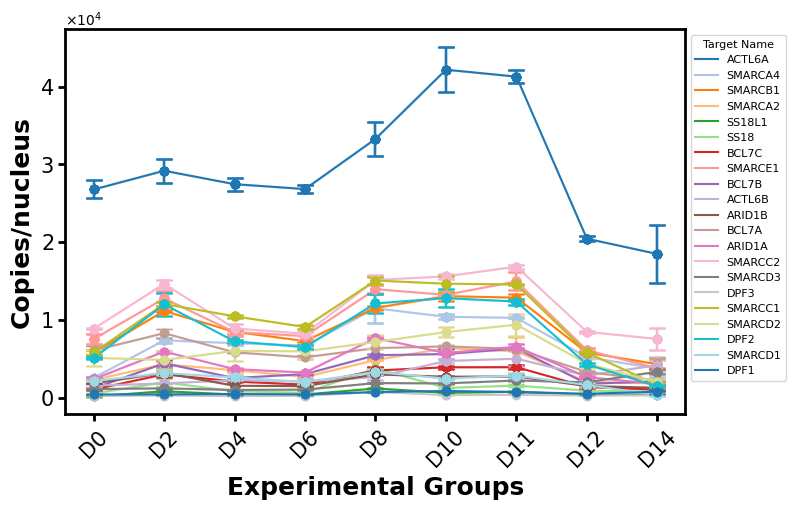

In [ ]:
#@title **Display Trend Plot**
#@markdown - Plots trend lines for the abundance of selected proteins
#@markdown - Error bars correspond to standard deviation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import ipywidgets as widgets
from IPython.display import display

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/Absolute_quantitative_parameters.csv'
df = pd.read_csv(file_path)

search_by_dropdown = widgets.Dropdown(
    options=['Protein Name', 'Genes'],
    value='Protein Name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

group_names_input = widgets.SelectMultiple(
    options=[],
    description='Target:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'},
    visible=False
)

y_axis_title_dropdown = widgets.Dropdown(
    options=['Copies/nucleus', 'Copies/cell'],
    value='Copies/nucleus',
    description='Y-axis title:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

def update_options(change):
    if change['new'] == 'Protein Name':
        options = df['Protein Name'].unique().tolist()
    else:
        options = df['Genes'].unique().tolist()

    group_names_input.options = options
    group_names_input.visible = True

search_by_dropdown.observe(update_options, names='value')

button = widgets.Button(
    description="Generate Trend Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)

def update_plot(protein_names):
    if search_by_dropdown.value == 'Protein Name':
        filtered_df = df[df['Protein Name'].isin(protein_names)]
    else:
        filtered_df = df[df['Genes'].isin(protein_names)]

    if filtered_df.empty:
        print("No data found for the selected proteins.")
        return

    colors = sns.color_palette("tab20", len(protein_names))

    fig, ax = plt.subplots(figsize=(8, 5))

    for i, protein in enumerate(protein_names):
        if search_by_dropdown.value == 'Protein Name':
            protein_data = filtered_df[filtered_df['Protein Name'] == protein]
        else:
            protein_data = filtered_df[filtered_df['Genes'] == protein]

        sns.lineplot(x='Experimental groups', y='Median Abundance for Experimental Group', data=protein_data, label=protein, color=colors[i], ax=ax)

        ax.errorbar(protein_data['Experimental groups'],
                     protein_data['Median Abundance for Experimental Group'],
                     yerr=protein_data['Standard Deviation for Experimental Group'],
                     fmt='o', capsize=6, color=colors[i])

    ax.set_xlabel("Experimental Groups", fontweight='bold', fontsize=18)

    ax.set_ylabel(y_axis_title_dropdown.value, fontweight='bold', fontsize=18)

    ax.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    ax.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    plt.legend(title='Target Name', fontsize=8, title_fontsize='8', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(False)

    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    plt.savefig('PLOTS/Trend_plots.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

def on_button_click(b):
    protein_names = group_names_input.value
    update_plot(protein_names)

button.on_click(on_button_click)
display(search_by_dropdown, group_names_input, y_axis_title_dropdown, button)

##**Statistical analysis with ANOVA and Tukey post-hoc statistical test**

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein Name', 'Genes'), style=Descr…

Dropdown(description='Target:', layout=Layout(width='auto'), options=(), style=DescriptionStyle(description_wi…

Dropdown(description='Y-axis title:', layout=Layout(width='auto'), options=('Copies/nucleus', 'Copies/cell'), …

Button(description='Generate Statistical Report and Plot', layout=Layout(height='80px', width='auto'), style=B…

Statistical analysis report was saved as: TABLES/Post_hoc_comparisons_selected_protein_for_stats.csv
Different letters denote significant differences (P < 0.05) by ANOVA with Tukey’s post-hoc test


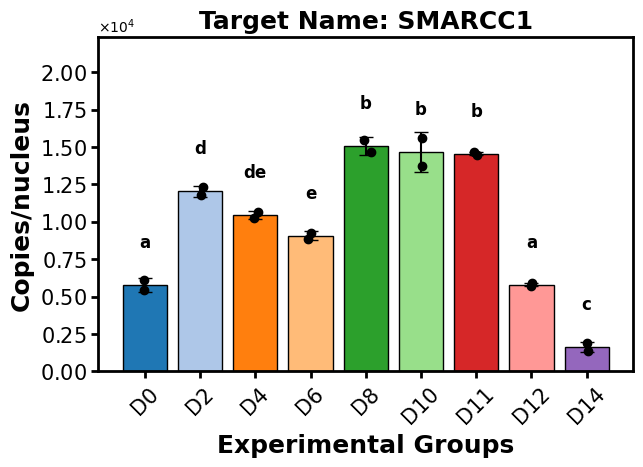

In [ ]:
#@title **Stoichiometric changes of a protein across experimental groups**
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import compactletterdisplay
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['font.family'] = 'DejaVu Sans'

search_by_dropdown = widgets.Dropdown(
    options=['Protein Name', 'Genes'],
    value='Protein Name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

group_names_input = widgets.Dropdown(
    options=[],
    description='Target:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'},
    visible=False
)

y_axis_title_dropdown = widgets.Dropdown(
    options=['Copies/nucleus', 'Copies/cell'],
    value='Copies/nucleus',
    description='Y-axis title:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(
    description="Generate Statistical Report and Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)

def update_options(change):
    file_path = 'TABLES/Absolute_quantitative_parameters.csv'
    df = pd.read_csv(file_path)

    if change['new'] == 'Protein Name':
        options = df['Protein Name'].str.strip().unique().tolist()
    else:
        options = df['Genes'].str.strip().unique().tolist()

    group_names_input.options = options
    group_names_input.visible = True

search_by_dropdown.observe(update_options, names='value')

def process_and_display_tables(b):
    file_path = 'TABLES/Absolute_quantitative_parameters.csv'
    df = pd.read_csv(file_path)

    df['Protein Name'] = df['Protein Name'].str.strip()
    df['Genes'] = df['Genes'].str.strip()

    protein_name = group_names_input.value

    filtered_df = df[df[search_by_dropdown.value] == protein_name]

    numeric_cols = filtered_df.select_dtypes(include=np.number).columns
    aggregated_df = filtered_df.groupby(['Sample', 'Experimental groups'])[numeric_cols].median().reset_index()

    original_order = filtered_df['Experimental groups'].unique()
    aggregated_df['Experimental groups'] = pd.Categorical(aggregated_df['Experimental groups'], categories=original_order, ordered=True)

    pivot_table = aggregated_df.pivot(
        index='Sample',
        columns='Experimental groups',
        values='Median Copy number per nucleus or cell per replicate'
    )

    pivot_table = pivot_table.apply(lambda x: pd.Series(x.dropna().values))
    pivot_table.reset_index(drop=True, inplace=True)

    if not pivot_table.empty:
        output_file_path = 'TABLES/Pivoted_Quantitative_parameters_selected_protein_for_stats.csv'
        pivot_table.to_csv(output_file_path, index=False)

        df = pd.read_csv(output_file_path)
        df_melted = df.melt(var_name='treatment', value_name='value')

        tukey = pairwise_tukeyhsd(endog=df_melted['value'], groups=df_melted['treatment'], alpha=0.05)
        pairwise_comps_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
        pairwise_comps_df.to_csv('TABLES/Post_hoc_comparisons_selected_protein_for_stats.csv', index=False)

        print("Statistical analysis report was saved as: TABLES/Post_hoc_comparisons_selected_protein_for_stats.csv")
        print("Different letters denote significant differences (P < 0.05) by ANOVA with Tukey’s post-hoc test")

        columns = df.columns.tolist()
        alpha = 0.05
        result_df = compactletterdisplay.anova_cld(df, columns, alpha)
        result_df.to_csv('TABLES/Post_hoc_compact_letter_display_selected_protein_for_stats.csv', index=False)

        # Plotting
        pivoted_file_path = 'TABLES/Pivoted_Quantitative_parameters_selected_protein_for_stats.csv'
        df = pd.read_csv(pivoted_file_path)
        df = df.T
        df.columns.name = None
        df.index.name = 'Experimental groups'

        cld_file_path = 'TABLES/Post_hoc_compact_letter_display_selected_protein_for_stats.csv'
        cld_df = pd.read_csv(cld_file_path)

        df.index = pd.Categorical(df.index, categories=original_order, ordered=True)

        medians = df.median(axis=1)
        std_devs = df.std(axis=1)
        offset = max(std_devs) * 1.7
        fig, ax = plt.subplots()

        groups = df.index
        colors = sns.color_palette('tab20', len(groups))

        bars = ax.bar(medians.index, medians.values, yerr=std_devs.values, capsize=5, color=colors, edgecolor='black')

        for i, group in enumerate(df.index):
            y = df.loc[group].dropna()
            x = np.random.normal(i, 0.04, size=len(y))
            ax.plot(x, y, 'o', color='black')

        for i, bar in enumerate(bars):
            height = bar.get_height()
            group_name = medians.index[i]
            cld = cld_df.loc[cld_df['Group'] == group_name, 'CLD'].values[0]
            ax.text(bar.get_x() + bar.get_width() / 2, height + offset, cld, ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')

        ax.set_title(f'Target Name: {protein_name}', fontweight='bold', fontsize=18)
        ax.set_xlabel('Experimental Groups', fontsize=18, fontweight='bold')
        ax.set_ylabel(y_axis_title_dropdown.value, fontsize=18, fontweight='bold')
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
        plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
        plt.xticks(rotation=45, fontsize=15)
        plt.yticks(fontsize=15)
        plt.tight_layout()

        ax1 = plt.gca()
        for spine in ax1.spines.values():
            spine.set_linewidth(2)
            spine.set_color("k")

        ax.margins(y=0.4)
        fig.savefig('PLOTS/Abundance_barplot_selected_protein_with_stats_post_hoc.tiff', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No data available for the selected protein/genes and experimental groups.")

button.on_click(process_and_display_tables)
display(search_by_dropdown, group_names_input, y_axis_title_dropdown, button)

Dropdown(description='Experimental group:', layout=Layout(width='auto'), options=(), style=DescriptionStyle(de…

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein Name', 'Genes'), style=Descr…

SelectMultiple(description='Targets:', layout=Layout(width='auto'), options=(), style=DescriptionStyle(descrip…

Dropdown(description='Y-axis title:', layout=Layout(width='auto'), options=('Copies/nucleus', 'Copies/cell'), …

Button(description='Generate Statistical Report and Plot', layout=Layout(height='80px', width='auto'), style=B…

Statistical analysis report was saved as: TABLES/Post_hoc_comparisons_selected_genes_for_stats.csv
Different letters denote significant differences (P < 0.05) by ANOVA with Tukey’s post-hoc test


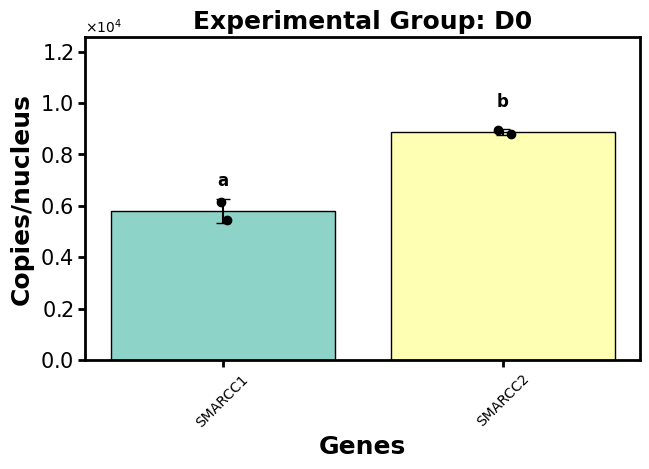

In [ ]:
#@title **Stoichiometric changes in the proteome of an experimental group**
#@markdown - IMPORTANT: Select more than one target protein
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import compactletterdisplay
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['font.family'] = 'DejaVu Sans'

experimental_group_input = widgets.Dropdown(
    options=[],
    description='Experimental group:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

search_by_dropdown = widgets.Dropdown(
    options=['Protein Name', 'Genes'],
    value='Protein Name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

group_names_input = widgets.SelectMultiple(
    options=[],
    description='Targets:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'},
    visible=False
)

y_axis_title_dropdown = widgets.Dropdown(
    options=['Copies/nucleus', 'Copies/cell'],
    value='Copies/nucleus',
    description='Y-axis title:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(
    description="Generate Statistical Report and Plot",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)

def update_experimental_group_options():
    file_path = 'TABLES/Absolute_quantitative_parameters.csv'
    df = pd.read_csv(file_path)

    options = df['Experimental groups'].str.strip().unique().tolist()
    experimental_group_input.options = options

def update_target_options(change):
    file_path = 'TABLES/Absolute_quantitative_parameters.csv'
    df = pd.read_csv(file_path)

    if change['new'] == 'Protein Name':
        options = df['Protein Name'].str.strip().unique().tolist()
    else:
        options = df['Genes'].str.strip().unique().tolist()

    group_names_input.options = options
    group_names_input.visible = True

search_by_dropdown.observe(update_target_options, names='value')

def process_and_display_tables(b):
    try:
        file_path = 'TABLES/Absolute_quantitative_parameters.csv'
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return

    experimental_group = experimental_group_input.value
    targets = group_names_input.value

    filtered_df = df[(df['Experimental groups'] == experimental_group) & (df[search_by_dropdown.value].isin(targets))]

    numeric_cols = filtered_df.select_dtypes(include=np.number).columns
    aggregated_df = filtered_df.groupby(['Sample', search_by_dropdown.value])[numeric_cols].median().reset_index()

    pivot_table = aggregated_df.pivot(
        index='Sample',
        columns=search_by_dropdown.value,
        values='Median Copy number per nucleus or cell per replicate'
    )

    pivot_table = pivot_table.apply(lambda x: pd.Series(x.dropna().values))
    pivot_table.reset_index(drop=True, inplace=True)

    output_file_path = f'TABLES/Pivoted_Quantitative_parameters_selected_{search_by_dropdown.value.lower()}_for_stats.csv'
    pivot_table.to_csv(output_file_path, index=False)

    df = pd.read_csv(output_file_path)
    df_melted = df.melt(var_name='treatment', value_name='value')

    tukey = pairwise_tukeyhsd(endog=df_melted['value'], groups=df_melted['treatment'], alpha=0.05)
    pairwise_comps_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    pairwise_comps_df.to_csv(f'TABLES/Post_hoc_comparisons_selected_{search_by_dropdown.value.lower()}_for_stats.csv', index=False)

    print(f"Statistical analysis report was saved as: TABLES/Post_hoc_comparisons_selected_{search_by_dropdown.value.lower()}_for_stats.csv")
    print("Different letters denote significant differences (P < 0.05) by ANOVA with Tukey’s post-hoc test")

    columns = df.columns.tolist()
    alpha = 0.05
    result_df = compactletterdisplay.anova_cld(df, columns, alpha)
    result_df.to_csv(f'TABLES/Post_hoc_compact_letter_display_selected_{search_by_dropdown.value.lower()}_for_stats.csv', index=False)

    pivoted_file_path = f'TABLES/Pivoted_Quantitative_parameters_selected_{search_by_dropdown.value.lower()}_for_stats.csv'
    df = pd.read_csv(pivoted_file_path)
    df = df.T
    df.columns.name = None
    df.index.name = search_by_dropdown.value

    cld_file_path = f'TABLES/Post_hoc_compact_letter_display_selected_{search_by_dropdown.value.lower()}_for_stats.csv'
    cld_df = pd.read_csv(cld_file_path)

    medians = df.median(axis=1)
    std_devs = df.std(axis=1)
    offset = max(std_devs) * 1.7
    fig, ax = plt.subplots()

    groups = df.index
    colors = sns.color_palette('Set3', len(groups))

    bars = ax.bar(medians.index, medians.values, yerr=std_devs.values, capsize=5, color=colors, edgecolor='black')

    for i, group in enumerate(df.index):
        y = df.loc[group].dropna()
        x = np.random.normal(i, 0.04, size=len(y))
        ax.plot(x, y, 'o', color='black')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        group_name = medians.index[i]
        cld = cld_df.loc[cld_df['Group'] == group_name, 'CLD'].values[0]
        ax.text(bar.get_x() + bar.get_width() / 2, height + offset, cld, ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')

    ax.set_title(f'Experimental Group: {experimental_group}', fontweight='bold', fontsize=18)
    ax.set_xlabel(search_by_dropdown.value, fontsize=18, fontweight='bold')
    ax.set_ylabel(y_axis_title_dropdown.value, fontsize=18, fontweight='bold')
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    plt.tick_params(axis='x', which='both', bottom=True, length=5, width=2, color='black')
    plt.tick_params(axis='y', which='both', left=True, length=5, width=2, color='black')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=15)
    plt.tight_layout()

    ax1 = plt.gca()
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color("k")

    ax.margins(y=0.4)
    fig.savefig('PLOTS/Abundance_barplot_selected_group_with_stats_post_hoc.tiff', dpi=300, bbox_inches='tight')
    plt.show()

button.on_click(process_and_display_tables)
display(experimental_group_input, search_by_dropdown, group_names_input, y_axis_title_dropdown, button)

update_experimental_group_options()

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein Name', 'Genes'), style=Descr…

Text(value='', description='Name:', layout=Layout(width='auto'), placeholder='Enter Protein Name or Genes sepa…

Text(value='', description='Title:', layout=Layout(width='auto'), placeholder='Enter Heatmap Title', style=Des…

Button(description='Generate Heatmap', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_co…

The following names were not found in the dataset: ACTB, ARID2, BICRA, BICRAL, BRD7, BRD9, PHF10, PBRM1


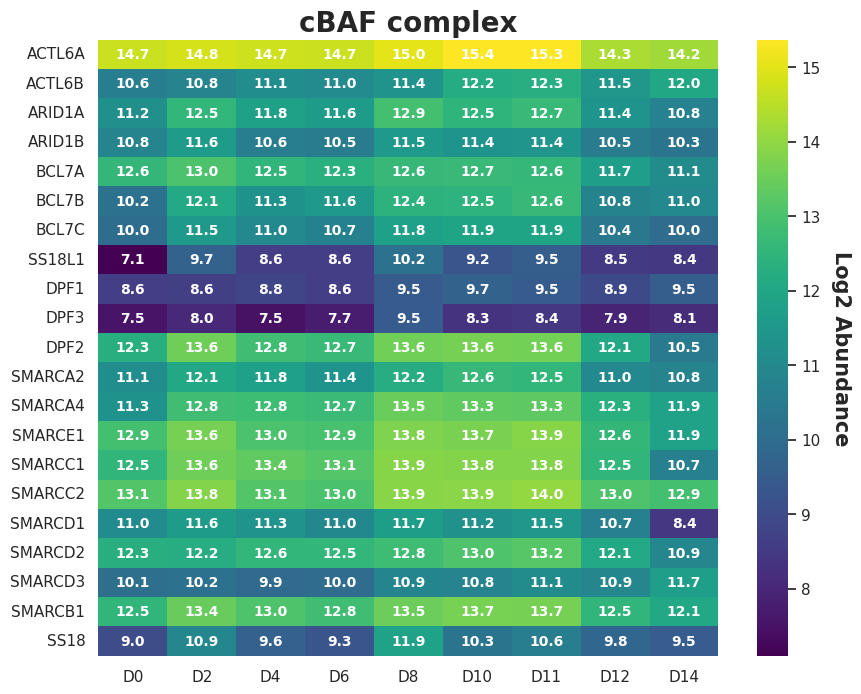

In [ ]:
#@title **Heatmap with no clustering for target protein/gene per experimental group**
#@markdown - Abundance values are subjected to log2 normalization methods
#@markdown - Values of each replicate are displayed
#@markdown - Missing values are displayed as "n.d" or not detectable

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/median_abundance.csv'
data = pd.read_csv(file_path)

protein_input = widgets.Text(
    value='',
    placeholder='Enter Protein Name or Genes separated by commas',
    description='Name:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

search_by_input = widgets.Dropdown(
    options=['Protein Name', 'Genes'],
    value='Protein Name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

title_input = widgets.Text(
    value='',
    placeholder='Enter Heatmap Title',
    description='Title:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(description="Generate Heatmap", style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'}, layout=widgets.Layout(
    width='auto',
    height='80px'
))

def generate_heatmap(names, search_by, title):
    desired_order = [name.strip() for name in names.split(',')]

    if search_by == 'Protein Name':
        filtered_data = data[data['Protein Name'].isin(desired_order)]
        index_column = 'Protein Name'
    elif search_by == 'Genes':
        filtered_data = data[data['Genes'].isin(desired_order)]
        index_column = 'Genes'
    else:
        print(f"Invalid search criteria: {search_by}")
        return

    found_names = filtered_data[index_column].tolist()
    not_found_names = [name for name in desired_order if name not in found_names]

    if not found_names:
        print(f"No data found for {search_by}: {names}")
        return

    if not_found_names:
        print(f"The following names were not found in the dataset: {', '.join(not_found_names)}")

    valid_columns = data.columns[2:]
    filtered_data = filtered_data[[index_column] + list(valid_columns)]
    filtered_data.set_index(index_column, inplace=True)
    filtered_data = filtered_data.loc[found_names]
    filtered_data = filtered_data.apply(pd.to_numeric, errors='coerce')

    log2_values = np.log2(filtered_data)

    sns.set(font_scale=1.0)
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(data=log2_values, cmap="viridis", annot=False, fmt=".1f", linewidths=0, linecolor='black', yticklabels=True)

    for i, (name, values) in enumerate(log2_values.iterrows()):
        for j, value in enumerate(values):
            if pd.notna(value):
                plt.text(j + 0.5, i + 0.5, f"{value:.1f}", ha="center", va="center", color="white", fontsize=10, fontweight="bold")
            else:
                plt.text(j + 0.5, i + 0.5, "n.d.", ha="center", va="center", color="red", fontsize=10, fontweight="bold")

    heatmap.set_ylabel("", fontweight='bold', fontsize=20)
    cbar = heatmap.collections[0].colorbar
    cbar.set_label("Log2 Abundance", fontsize=15, labelpad=15, rotation=270, verticalalignment='center', fontweight='bold')
    plt.setp(plt.gca(), facecolor='none')
    plt.title(title, fontsize=20, fontweight='bold')
    file_name = f'PLOTS/Heatmap_no_clustering_experimental_groups_log2_{title.replace(" ", "_")}.tiff'
    plt.savefig(file_name, format='tiff', dpi=300, bbox_inches='tight')

    plt.show()

def on_button_click(b):
    generate_heatmap(protein_input.value, search_by_input.value, title_input.value)

button.on_click(on_button_click)

display(search_by_input, protein_input, title_input, button)

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein Name', 'Genes'), style=Descr…

Text(value='', description='Title:', layout=Layout(width='auto'), placeholder='Enter Heatmap Title', style=Des…

Button(description='Generate Heatmap', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_co…

<Figure size 800x800 with 0 Axes>

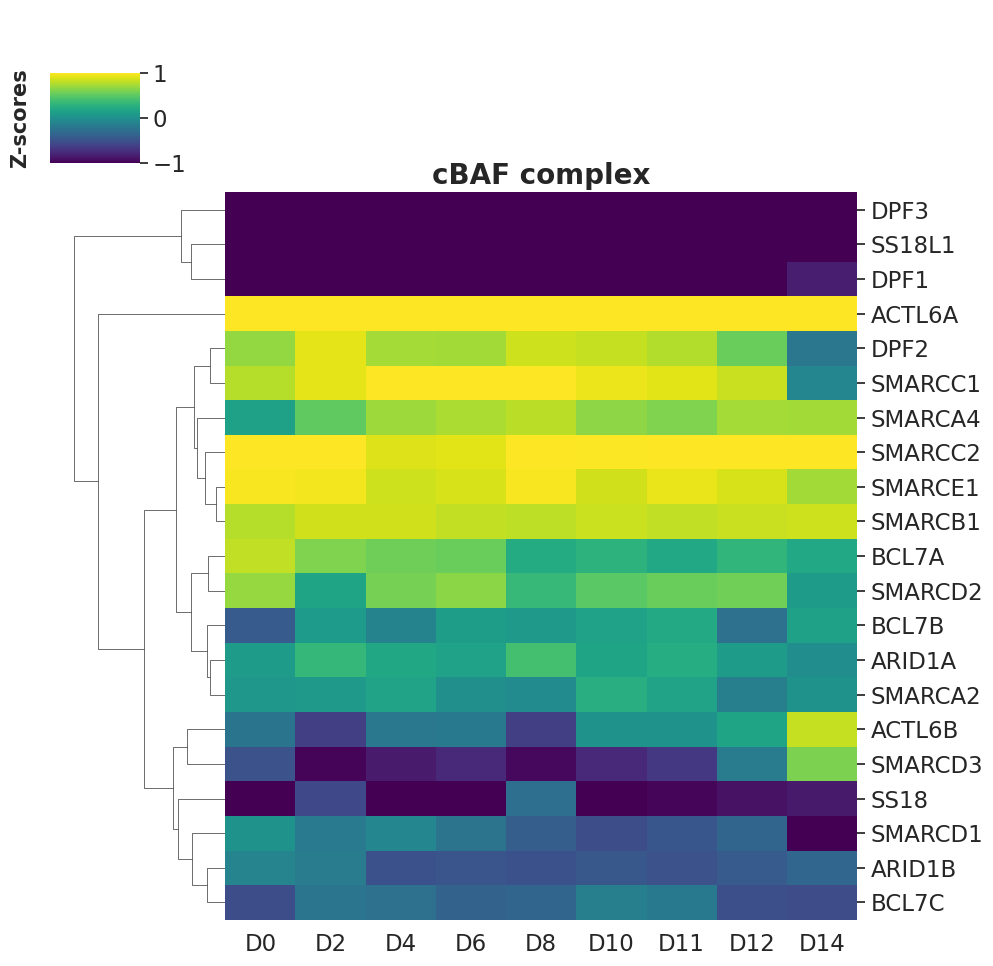

In [ ]:
#@title **Hierarchical clustering heatmap for experimental groups**
#@markdown - Abundance values are subjected to log2 and z-score normalization methods

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
from sklearn.exceptions import ConvergenceWarning
import ipywidgets as widgets
from IPython.display import display

warnings.filterwarnings("ignore", category=ConvergenceWarning)

plt.rcParams['font.family'] = 'DejaVu Sans'


file_path = 'TABLES/median_abundance.csv'
data = pd.read_csv(file_path)

data = data.drop(columns=['Genes'])
valid_columns = data.columns[1:].tolist()

search_by_input = widgets.Dropdown(
    options=['Protein Name', 'Genes'],
    value='Protein Name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

title_input = widgets.Text(
    value='',
    placeholder='Enter Heatmap Title',
    description='Title:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(
    description="Generate Heatmap",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)

def generate_heatmap(search_by, title):
    if search_by == 'Genes':
        data_with_genes = pd.read_csv(file_path)
        filtered_data = data_with_genes[['Genes'] + valid_columns].copy()
        filtered_data.set_index('Genes', inplace=True)
    else:
        filtered_data = data[['Protein Name'] + valid_columns].copy()
        filtered_data.set_index('Protein Name', inplace=True)

    imputer = IterativeImputer()
    imputed_data = imputer.fit_transform(filtered_data)
    imputed_df = pd.DataFrame(imputed_data, index=filtered_data.index, columns=filtered_data.columns)

    log2_data = imputed_df.apply(lambda col: col.map(lambda x: np.log2(float(x)) if pd.notnull(x) and float(x) > 0 else np.nan))
    z_scores_df = (log2_data - log2_data.mean()) / log2_data.std()
    z_scores_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    z_scores_df.dropna(inplace=True)

    sns.set(font_scale=1.5)
    plt.figure(figsize=(8, 8))
    cmap = sns.color_palette("viridis", as_cmap=True)
    heatmap = sns.clustermap(data=z_scores_df, cmap=cmap, annot=False, fmt=".1f", linewidths=0, linecolor='black', yticklabels=True, vmin=-1, vmax=1, col_cluster=False, cbar_pos=(0.01, 0.82, 0.09, 0.09))

    heatmap.ax_heatmap.set_ylabel("", fontweight='bold', fontsize=20)
    heatmap.ax_heatmap.set_title(title, fontweight='bold', fontsize=20)

    cbar = heatmap.ax_heatmap.collections[0].colorbar
    cbar.set_label("Z-scores", fontsize=15, labelpad=-120, rotation=90, verticalalignment='center', fontweight='bold')

    plt.savefig('PLOTS/Clustering_Heatmap_total_proteome_Iterative_imputation.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

def on_button_click(b):
    generate_heatmap(search_by_input.value, title_input.value)

button.on_click(on_button_click)

display(search_by_input)
display(title_input)
display(button)

Dropdown(description='Search by:', layout=Layout(width='auto'), options=('Protein Name', 'Genes'), style=Descr…

Text(value='', description='Title:', layout=Layout(width='auto'), placeholder='Enter Heatmap Title', style=Des…

Button(description='Generate Heatmap', layout=Layout(height='80px', width='auto'), style=ButtonStyle(button_co…

<Figure size 800x800 with 0 Axes>

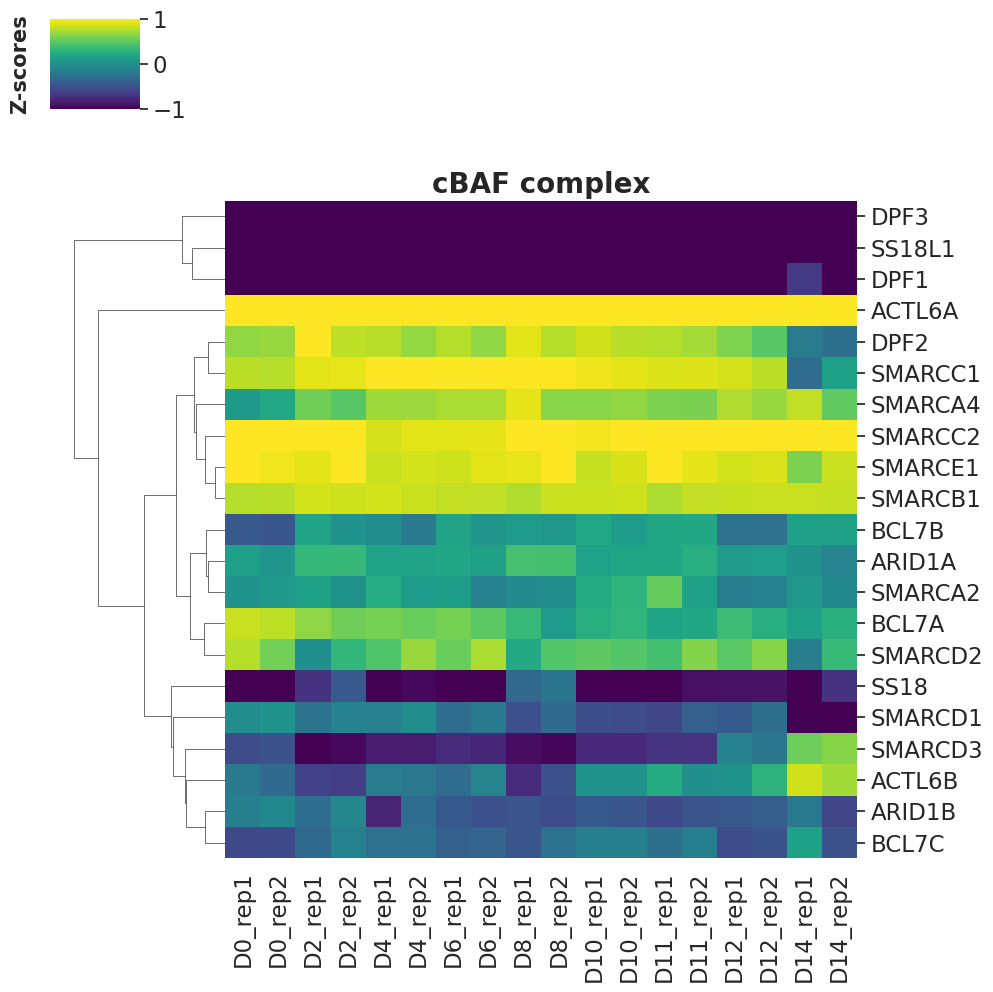

In [ ]:
#@title **Hierarchical clustering heatmap for each sample**
#@markdown - Abundance values are subjected to log2 and z-score normalization methods

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
from sklearn.exceptions import ConvergenceWarning
import ipywidgets as widgets
from IPython.display import display

warnings.filterwarnings("ignore", category=ConvergenceWarning)

plt.rcParams['font.family'] = 'DejaVu Sans'

file_path = 'TABLES/melted_protein_data_samples.csv'
data = pd.read_csv(file_path)

data = data.drop(columns=['Genes'])
valid_columns = data.columns[1:].tolist()

search_by_input = widgets.Dropdown(
    options=['Protein Name', 'Genes'],
    value='Protein Name',
    description='Search by:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

title_input = widgets.Text(
    value='',
    placeholder='Enter Heatmap Title',
    description='Title:',
    layout=widgets.Layout(width='auto', description_width='initial'),
    style={'description_width': 'initial', 'font_size': '16px'}
)

button = widgets.Button(
    description="Generate Heatmap",
    style={'font_weight': 'bold', 'button_color': '#4CAF50', 'font_size': '16px'},
    layout=widgets.Layout(width='auto', height='80px')
)

def generate_heatmap(search_by, title):
    if search_by == 'Genes':
        data_with_genes = pd.read_csv(file_path)
        filtered_data = data_with_genes[['Genes'] + valid_columns].copy()
        filtered_data.set_index('Genes', inplace=True)
    else:
        filtered_data = data[['Protein Name'] + valid_columns].copy()
        filtered_data.set_index('Protein Name', inplace=True)

    imputer = IterativeImputer(max_iter=100, random_state=0)
    imputed_data = imputer.fit_transform(filtered_data)
    imputed_df = pd.DataFrame(imputed_data, index=filtered_data.index, columns=filtered_data.columns)

    log2_data = imputed_df.apply(lambda col: col.map(lambda x: np.log2(float(x)) if pd.notnull(x) and float(x) > 0 else np.nan))
    z_scores_df = (log2_data - log2_data.mean()) / log2_data.std()
    z_scores_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    z_scores_df.dropna(inplace=True)

    sns.set(font_scale=1.5)
    plt.figure(figsize=(8, 8))
    cmap = sns.color_palette("viridis", as_cmap=True)
    heatmap = sns.clustermap(data=z_scores_df, cmap=cmap, annot=False, fmt=".1f", linewidths=0, linecolor='black', yticklabels=True, vmin=-1, vmax=1, col_cluster=False, cbar_pos=(0.01, 0.9, 0.09, 0.09))

    heatmap.ax_heatmap.set_ylabel("", fontweight='bold', fontsize=20)
    heatmap.ax_heatmap.set_title(title, fontweight='bold', fontsize=20)

    cbar = heatmap.ax_heatmap.collections[0].colorbar
    cbar.set_label("Z-scores", fontsize=15, labelpad=-120, rotation=90, verticalalignment='center', fontweight='bold')

    plt.savefig('PLOTS/Heatmap_total_proteome_samples_Iterative_imputation.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

def on_button_click(b):
    generate_heatmap(search_by_input.value, title_input.value)

button.on_click(on_button_click)

display(search_by_input)
display(title_input)
display(button)


